In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import datetime
import sys

import math


In [4]:
# directory with interim charles river data results
results_file = "../data/charles_river_samples_interim/results_merged_cleaned.csv"

In [5]:
results = pd.read_csv(results_file)

In [6]:
# starting with code to understand the data ...

In [7]:
# research 
# show the results file contents
results

,Date_Collected_Time_Collected,Activity_ID,Lab_ID,Site_ID,Project_ID,Actual_Result,Actual_Result_Unit_ID,Result_Sample_Fraction,Reporting_Result,Reporting_Result_Unit_ID,...,Percent_RPD,QAQC_Status,Data_Type_Name,Media_Type_Name,Media_Subdivision_Name,Component_Name,Activity_Type,Actual_Result_Type,Reporting_Result_Type,Relative_Depth_Name
0,2016-04-12 05:58:00,720160412ROV1DTH01,NaN,ROV1,7,0.67,5,NaN,0.67,5,...,372.0,Final-Accepted,Non-critical,Water,Surface Water,Depth,Field Msr/Obs,Actual,Actual,Surface
1,2016-05-17 05:58:00,720160517ROV1DTH01,NaN,ROV1,7,0.46,5,NaN,5.50,5,...,2.0,Final-Accepted,Non-critical,Water,Surface Water,Depth,Field Msr/Obs,Actual,Actual,Surface
2,2016-07-19 06:45:00,720160719ROV1DTH01,NaN,ROV1,7,0.33,5,NaN,0.33,5,...,2.0,Final-Accepted,Non-critical,Water,Surface Water,Depth,Field Msr/Obs,Actual,Actual,Surface
3,2016-07-19 07:00:00,720160719ROV2DTH01,NaN,ROV2,7,0.5,5,NaN,0.50,5,...,4.0,Final-Accepted,Non-critical,Water,Surface Water,Depth,Field Msr/Obs,Actual,Actual,Surface
4,2016-08-16 07:17:00,720160816ROV1DTH01,NaN,ROV1,7,0.33,5,NaN,0.33,5,...,6.0,Final-Accepted,Non-critical,Water,Surface Water,Depth,Field Msr/Obs,Actual,Actual,Surface
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46445,2008-08-11 09:46:39,FLG200808113BUTemp03,NaN,3BU,3,20.36,4,Total,20.36,4,...,NaN,Preliminary,Critical,Water,Surface Water,"Temperature, water",Field Msr/Obs,Actual,Actual,Bottom
46446,2008-08-11 09:15:20,FLG200808114LONGTemp02,NaN,4LONG,3,21.33,4,Total,21.33,4,...,NaN,Preliminary,Critical,Water,Surface Water,"Temperature, water",Field Msr/Obs,Actual,Actual,Bottom
46447,2008-08-11 09:15:31,FLG200808114LONGTemp03,NaN,4LONG,3,21.33,4,Total,21.33,4,...,NaN,Preliminary,Critical,Water,Surface Water,"Temperature, water",Field Msr/Obs,Actual,Actual,Bottom
46448,2008-08-11 09:21:29,FLG200808114LONGTemp05,NaN,4LONG,3,21.31,4,Total,21.31,4,...,NaN,Preliminary,Critical,Water,Surface Water,"Temperature, water",Field Msr/Obs,Actual,Actual,Bottom


In [8]:
# research:
# all 'Media_Subdivision_Name' values are surface water
pd.unique(results['Media_Subdivision_Name'])

array(['Surface Water'], dtype=object)

In [9]:
# research
# many different types of measurements are in 'Component_Name'
pd.unique(results['Component_Name'])

array(['Depth', 'Temperature, water', 'Escherichia coli', 'Enterococcus',
       'Fecal coliform', 'Inorganic nitrogen (nitrate and nitrite)',
       'Phosphorus', 'Total suspended solids', 'Chlorophyll a',
       'Pheophytin a', 'Nitrogen', 'Ammonia', 'Orthophosphate', 'Sodium',
       'Conductivity', 'Surfactants, anionic', 'Nitrite', 'Nitrate',
       'Chlorine', 'Ammonium', 'Barometric pressure',
       'Dissolved oxygen saturation', 'Dissolved oxygen (DO)', 'Salinity',
       'Algae, blue-green (phylum cyanophyta) density', 'pH',
       'Specific conductance'], dtype=object)

In [10]:
# convert Date_Collected_Time_Collected from string to datetime 
# (data type is actually pandas._libs.tslibs.timestamps.Timestamp )

results['Date_Collected_Time_Collected'] = pd.to_datetime( results['Date_Collected_Time_Collected'] )
( results['Date_Collected_Time_Collected'][6657] )

Timestamp('2016-04-12 05:58:00')

In [11]:
# create new column:  which indicates the season collected

# season is an int indicating the year and season (first four digits are the year, and the last digit is the season)
# dates in December are treated as winter of the next year, so seasonal results are kept together
# winter ends with 1, spring ends with 2, summer ends with 3, autumn ends with 4

# This link discusses why meteorologists define the seasons this way
# https://www.ncei.noaa.gov/news/meteorological-versus-astronomical-seasons

def date_to_season(date):
    season = date.year*10; # first four digits will be the year
    
    if date.month == 12: # treat December as winter of the next year
       season += 11
    elif date.month < 3: # Jan and Feb are winter of the same year
        season += 1
    elif date.month < 6: # March, April, May are spring
        season += 2
    elif date.month < 9: # June, July, August are summer
        season += 3
    else:
        season += 4
        
    return season;

results['Season_Collected'] = (results["Date_Collected_Time_Collected"]).apply(date_to_season)

In [12]:
# create a year column

results['Year'] = results.Date_Collected_Time_Collected.apply(lambda row: row.year)

type(results.Date_Collected_Time_Collected[0])

pandas._libs.tslibs.timestamps.Timestamp

In [13]:
# focusing on water temperature

In [14]:
# from results table, only pull out the records (rows) for water temperature, and only pull out a few fields (columns)

results_temperature = results[results['Component_Name']=='Temperature, water'][['Date_Collected_Time_Collected', 'Season_Collected', 'Year', 'Reporting_Result']]
results_temperature

,Date_Collected_Time_Collected,Season_Collected,Year,Reporting_Result
6657,2016-04-12 05:58:00,20162,2016,14.50
6658,2016-05-17 05:58:00,20162,2016,15.00
6659,2016-09-20 06:00:00,20164,2016,20.50
6660,2016-09-20 05:25:00,20164,2016,21.30
6661,2016-11-15 06:15:00,20164,2016,14.80
...,...,...,...,...
46445,2008-08-11 09:46:39,20083,2008,20.36
46446,2008-08-11 09:15:20,20083,2008,21.33
46447,2008-08-11 09:15:31,20083,2008,21.33
46448,2008-08-11 09:21:29,20083,2008,21.31


In [15]:
# research only

# list all seasons where this data was collected
# note:  no temperature measurements from Spring 2002 through Winter 2002/3
np.sort( results_temperature['Season_Collected'].unique() )

array([19953, 19954, 19962, 19963, 19964, 19971, 19972, 19973, 19974,
       19981, 19982, 19983, 19984, 19991, 19992, 19993, 19994, 20001,
       20002, 20003, 20004, 20011, 20012, 20013, 20014, 20021, 20032,
       20033, 20034, 20041, 20042, 20043, 20044, 20051, 20052, 20053,
       20054, 20061, 20062, 20063, 20064, 20071, 20072, 20073, 20074,
       20081, 20082, 20083, 20084, 20091, 20092, 20093, 20094, 20101,
       20102, 20103, 20104, 20111, 20112, 20113, 20114, 20121, 20122,
       20123, 20124, 20131, 20132, 20133, 20134, 20141, 20142, 20143,
       20144, 20151, 20152, 20153, 20154, 20161, 20162, 20163, 20164,
       20171, 20172, 20173, 20174, 20181, 20182, 20183, 20184, 20191],
      dtype=int64)

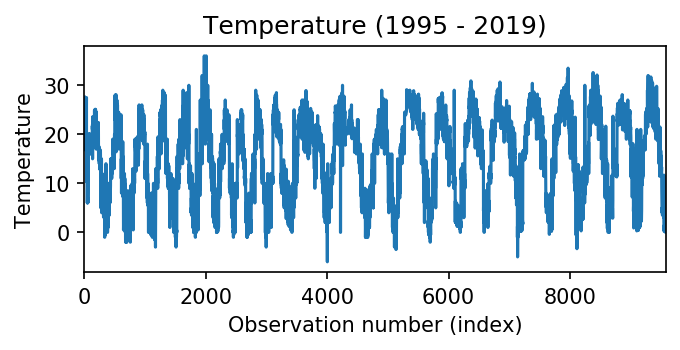

In [95]:
# plotting temperature results values:
# reset index is necessary make the index go from 0 to (length-1)

# note the cycle observed here is due to the change of seasons throughout the year

res_plot = ( results_temperature.sort_values(by=['Date_Collected_Time_Collected']) )['Reporting_Result']
plt.figure(figsize=(5,2), dpi=150)
ax = res_plot.reset_index(drop=True).plot()
ax.set_xlabel("Observation number (index)")
ax.set_ylabel("Temperature")
ax.set_title("Temperature (1995 - 2019)")
plt.show()


In [17]:
( results_temperature.sort_values(by=['Date_Collected_Time_Collected']) )

,Date_Collected_Time_Collected,Season_Collected,Year,Reporting_Result
6840,1995-06-06 06:00:00,19953,1995,27.6
6841,1995-06-06 06:00:00,19953,1995,23.0
6842,1995-06-06 06:00:00,19953,1995,22.3
6843,1995-06-06 06:00:00,19953,1995,22.6
6844,1995-06-06 06:00:00,19953,1995,22.8
...,...,...,...,...
13713,2018-12-11 06:05:00,20191,2018,1.5
13740,2018-12-11 06:08:00,20191,2018,0.3
13716,2018-12-11 06:09:00,20191,2018,0.0
13735,2018-12-11 06:09:00,20191,2018,1.9


In [18]:
# only use summertime data
# This is because people are more likely to go boating on and swimming in the
# Charles River during the summer, therefore summertime conditions are 
# anticipated to be more of interest to the CRWA than the other three seasons
results_temperature_summer = results_temperature[results_temperature['Season_Collected']%10 == 3]

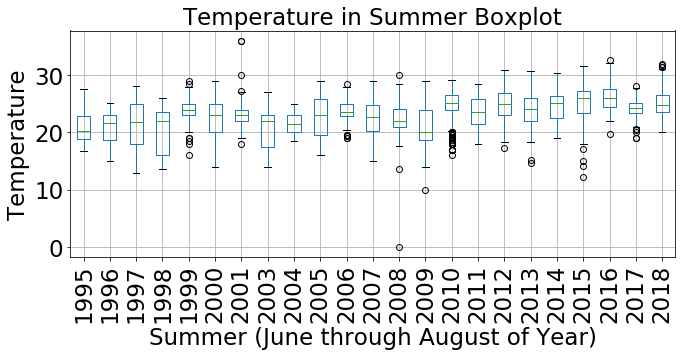

In [94]:
# create boxplot of summer data
# improvements wanted:
# space it out to show gap for missing 2002 data, create a linear regression showing the overall trend (if any)

the_fontsize=23

# boxplot command
ax = results_temperature_summer.boxplot(by='Year', column='Reporting_Result', rot=90, fontsize=the_fontsize, figsize=(10.5,4.2))

# labelling
ax.set_xlabel("Summer (June through August of Year)", fontsize=the_fontsize)
ax.set_ylabel("Temperature", fontsize=the_fontsize)
ax.set_title("Temperature in Summer Boxplot", fontsize=the_fontsize)
plt.suptitle("");




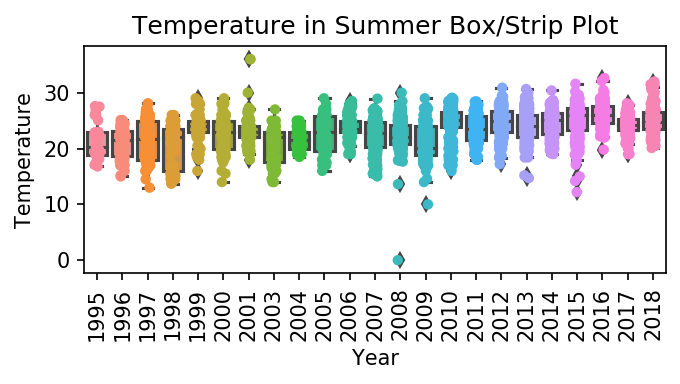

In [84]:
plt.figure(figsize=(5,2), dpi=150)
ax = sns.boxplot(x="Year", y="Reporting_Result", data=results_temperature_summer)
ax = sns.stripplot(x="Year", y="Reporting_Result", data=results_temperature_summer)
ax.set_xticklabels(rotation=90, labels=ax.get_xticklabels())
ax.set_ylabel("Temperature")
ax.set_title("Temperature in Summer Box/Strip Plot");

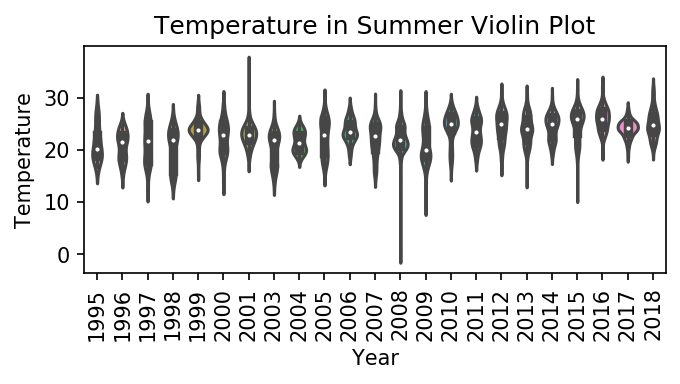

In [87]:
plt.figure(figsize=(5,2), dpi=150)
ax = sns.violinplot(x="Year", y="Reporting_Result", data=results_temperature_summer, rot=90)
ax.set_xticklabels(rotation=90, labels=ax.get_xticklabels())
ax.set_ylabel("Temperature")
ax.set_title("Temperature in Summer Violin Plot");

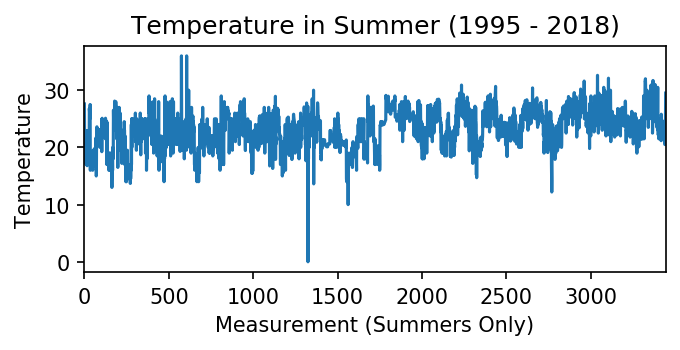

In [79]:
# plotting temperature results (summer only) values:
# reset index is necessary to make the index go from 0 to (length-1)
res_plot = ( results_temperature_summer.sort_values(by=['Date_Collected_Time_Collected']) )['Reporting_Result']
plt.figure(figsize=(5,2), dpi=150)
ax = res_plot.reset_index(drop=True).plot()
ax.set_xlabel("Measurement (Summers Only)")
ax.set_ylabel("Temperature")
ax.set_title("Temperature in Summer (1995 - 2018)")
plt.show()


In [23]:
# precipitation

In [24]:
# directory with precipitation measurements
rainfall_file = "../data/charles_river_samples_csv/Rainfall.csv"

In [25]:
rainfall = pd.read_csv(rainfall_file)

In [26]:
# research:
# data cleaning is needed because NaN values are in both columns
rainfall

,DATE,ID,Precipitation
0,01/01/1995,1,1.07
1,01/02/1995,2,0.44
2,01/03/1995,3,0.00
3,01/04/1995,4,0.00
4,01/05/1995,5,0.00
...,...,...,...
6052,NaN,6053,NaN
6053,NaN,6054,NaN
6054,NaN,6055,NaN
6055,NaN,6056,NaN


In [27]:
# data cleaning: drop all rows that have any NA values
rainfall = rainfall.dropna()

rainfall

,DATE,ID,Precipitation
0,01/01/1995,1,1.07
1,01/02/1995,2,0.44
2,01/03/1995,3,0.00
3,01/04/1995,4,0.00
4,01/05/1995,5,0.00
...,...,...,...
5939,3/12/2011,5940,0.00
5940,1/11/2011,5941,0.00
5941,1/10/2011,5942,0.00
5942,1/9/2011,5943,0.13


In [28]:
# convert date from string to datetime
# (data type is actually pandas._libs.tslibs.timestamps.Timestamp )

# turns off warning described in below webpages (it appears to be a false error)
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
# https://www.dataquest.io/blog/settingwithcopywarning/
pd.options.mode.chained_assignment = None  # default='warn'

# convert datatype here:
rainfall['DATE'] = pd.to_datetime( rainfall['DATE'] )

# turn warning back on:
pd.options.mode.chained_assignment = 'warn'

rainfall['DATE'][0]

Timestamp('1995-01-01 00:00:00')

In [29]:
# turns off warning described in below webpages (it appears to be a false error)
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
# https://www.dataquest.io/blog/settingwithcopywarning/
pd.options.mode.chained_assignment = None  # default='warn'

rainfall['Season_Collected'] = (rainfall["DATE"]).apply(date_to_season)

# turn warning back on:
pd.options.mode.chained_assignment = 'warn'

In [30]:
# create a year column (note most error turns off warning)

# turns off warning described in below webpages (it appears to be a false error)
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
# https://www.dataquest.io/blog/settingwithcopywarning/
pd.options.mode.chained_assignment = None  # default='warn'

# this line creates the year column
rainfall['Year'] = rainfall.DATE.apply(lambda row: row.year)

# turn warning back on:
pd.options.mode.chained_assignment = 'warn'


In [31]:
rainfall

,DATE,ID,Precipitation,Season_Collected,Year
0,1995-01-01,1,1.07,19951,1995
1,1995-01-02,2,0.44,19951,1995
2,1995-01-03,3,0.00,19951,1995
3,1995-01-04,4,0.00,19951,1995
4,1995-01-05,5,0.00,19951,1995
...,...,...,...,...,...
5939,2011-03-12,5940,0.00,20112,2011
5940,2011-01-11,5941,0.00,20111,2011
5941,2011-01-10,5942,0.00,20111,2011
5942,2011-01-09,5943,0.13,20111,2011


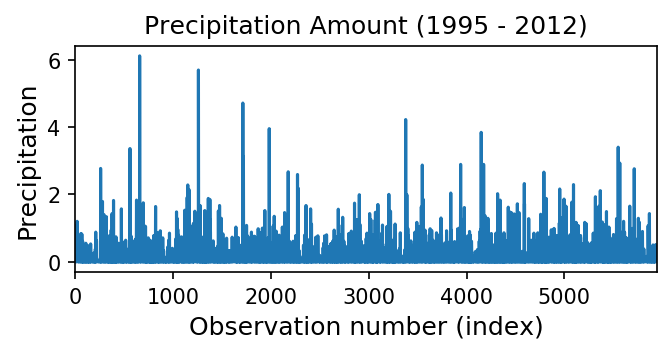

In [62]:
# plotting precipitation values:
# reset index is necessary make the index go from 0 to (length-1)

# note the cycle observed here is due to the change of seasons throughout the year

the_fontsize=12

rain_plot = ( rainfall.sort_values(by=['DATE']) )['Precipitation']
plt.figure(figsize=(5,2), dpi=150)
ax = rain_plot.reset_index(drop=True).plot()
ax.set_xlabel("Observation number (index)", fontsize=the_fontsize)
ax.set_ylabel("Precipitation", fontsize=the_fontsize)
ax.set_title("Precipitation Amount (1995 - 2012)")
plt.show()

In [42]:
# only use summertime data
# This is because people are more likely to go boating on and swimming in the
# Charles River during the summer, therefore summertime conditions are 
# anticipated to be more of interest to the CRWA than the other three seasons
rainfall_summer = rainfall[rainfall['Season_Collected']%10 == 3]
type(rainfall_summer)

pandas.core.frame.DataFrame

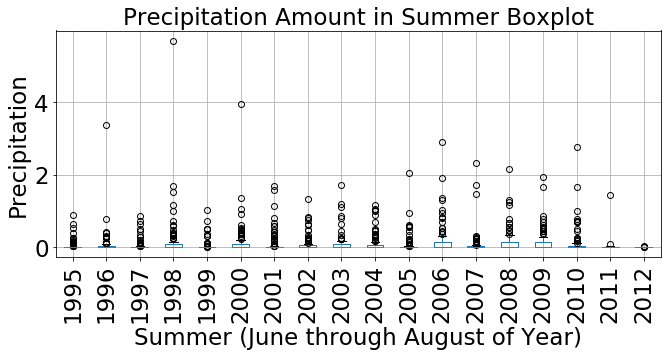

In [63]:
# create boxplot of summer data
# improvements wanted:  change title,
# use analysis showing the overall trend (if any)

# NOTE:  the most recent data is from 2012


the_fontsize=23

# boxplot command
ax = rainfall_summer.boxplot(by='Year', column='Precipitation', rot=90, fontsize=the_fontsize, figsize=(10.5,4.2))

# labelling
ax.set_xlabel("Summer (June through August of Year)", fontsize=the_fontsize)
ax.set_ylabel("Precipitation", fontsize=the_fontsize)

# leaving the set_title blank, because the shown title comes from somewhere else
# if I were to fill this in, I would get two titles that clash with each other ... therefore, I use an empty string
ax.set_title("Precipitation Amount in Summer Boxplot", fontsize=the_fontsize)
plt.suptitle("");





In [35]:
type(ax)

matplotlib.axes._subplots.AxesSubplot

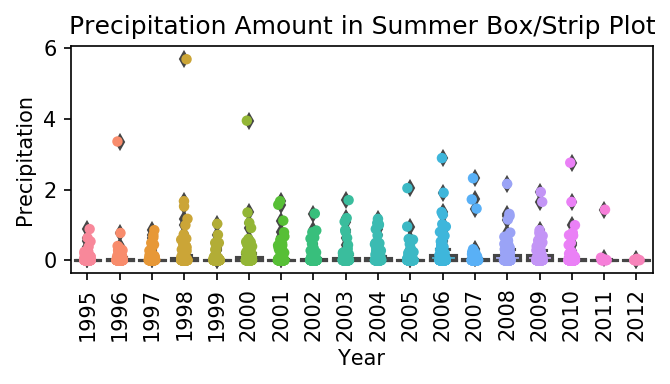

In [64]:
# using combined boxplot and stripplot
plt.figure(figsize=(5,2), dpi=150)
ax = sns.boxplot(x="Year", y="Precipitation", data=rainfall_summer)
ax = sns.stripplot(x="Year", y="Precipitation", data=rainfall_summer)
ax.set_xticklabels(rotation=90, labels=ax.get_xticklabels())
ax.set_title("Precipitation Amount in Summer Box/Strip Plot");

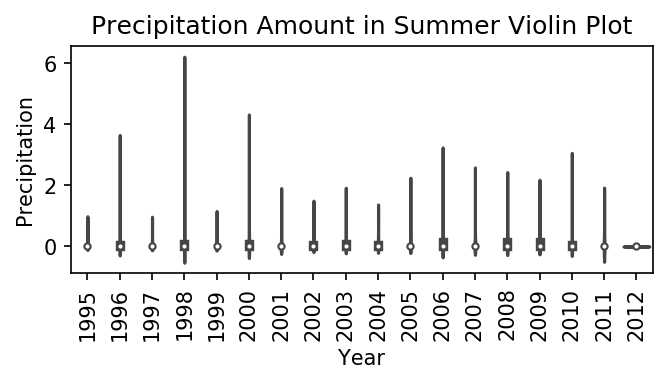

In [65]:
plt.figure(figsize=(5,2), dpi=150)
ax = sns.violinplot(x="Year", y="Precipitation", data=rainfall_summer)
ax.set_xticklabels(rotation=90, labels=ax.get_xticklabels())
ax.set_title("Precipitation Amount in Summer Violin Plot");

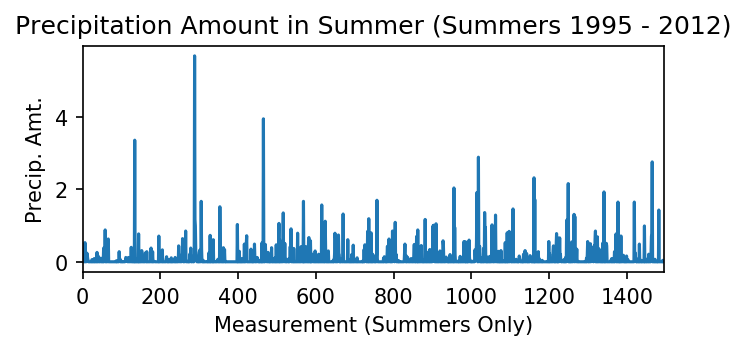

In [66]:
# plotting rainfall values:
# reset index is necessary make the index go from 0 to (length-1)

# note the cycle observed here is due to the change of seasons throughout the year

rain_plot = ( rainfall_summer.sort_values(by=['DATE']) )['Precipitation']
plt.figure(figsize=(5,2), dpi=150)
ax = rain_plot.reset_index(drop=True).plot()
ax.set_xlabel("Measurement (Summers Only)")
ax.set_ylabel("Precip. Amt.")
ax.set_title("Precipitation Amount in Summer (Summers 1995 - 2012)")
plt.show()